## Initialisation

In [ ]:
import os
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import imageio

## Data-Free Hard-constraint Physics-Informed Neural Network (PINN)

### Create directory

In [2]:
os.makedirs("training_outputs", exist_ok=True)

### Analytical Solution

In [ ]:
length = 1
T_hot = 100
T_cold = 20
diff_coeff = 1
density = 1
u = 10

def func(x):
  return T_hot + (np.exp(density * u * x / diff_coeff)-1) / (np.exp(density * u * length / diff_coeff)-1) * (T_cold - T_hot)


### Plot and gif functions

In [ ]:
def plot_and_save(step, model):
    # Predict the solution
    y_pred = model.predict(x)
    y_true = func(x)

    # Create the plot
    plt.figure(figsize=(8, 5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('#f0f0f0')
    plt.plot(x, y_true,'-x',color='#22223B',alpha=0.7,markersize=5, label='Analytical Solution')
    plt.plot(x, y_pred,'--',color='#D36135', label='PINN Prediction')
    plt.title(f'Solution at step {step}',fontsize=14,fontweight='bold',color='#22223B')
    plt.xlabel('x')
    plt.ylabel('Temperature')
    plt.legend(loc='lower left',fontsize=12,frameon=True,shadow=True,facecolor='white')

    # Save the plot
    plt.savefig(f"training_outputs/step_{step:06d}.png")
    plt.close()
    
def create_gif(image_folder, gif_name):
    images = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(gif_name, images, fps=20)

### Set up PINN

In [ ]:

geom = dde.geometry.Interval(0,length)

def pde(x,y):
  dy_dx = dde.grad.jacobian(y,x)
  d2y_dx2 = dde.grad.hessian(y,x)

  return density * u * dy_dx - diff_coeff * d2y_dx2



# What works: uniform distribution
data = dde.data.PDE(geom,
                    pde,
                    [],
                    num_domain=100, 
                    solution=func,
                    num_test=100,
                    train_distribution='uniform')

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation,initializer)

def output_transform(x, y):
    return T_hot + (T_cold - T_hot) * x / length + x * (x - length) * y

net.apply_output_transform(output_transform)



# Generate points for prediction
x = np.linspace(0, length, 50)[:, None]

class PlotCallback(dde.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.step = 0

    def on_epoch_end(self):
        if self.step == 0:
          plot_and_save(self.step, self.model)
        self.step += 1
        if self.step % 50 == 0:  # Save plot every 50 steps
            plot_and_save(self.step, self.model)

# Create the callback
plot_callback = PlotCallback()

model = dde.Model(data,net)
model.compile("adam", lr=0.001,metrics=["MSE"])
losshistory, train_state = model.train(iterations=25000,callbacks=[plot_callback])

dde.saveplot(losshistory,train_state,issave=False,isplot=True)



# Create the animation
create_gif('training_outputs', 'training_animation.gif')


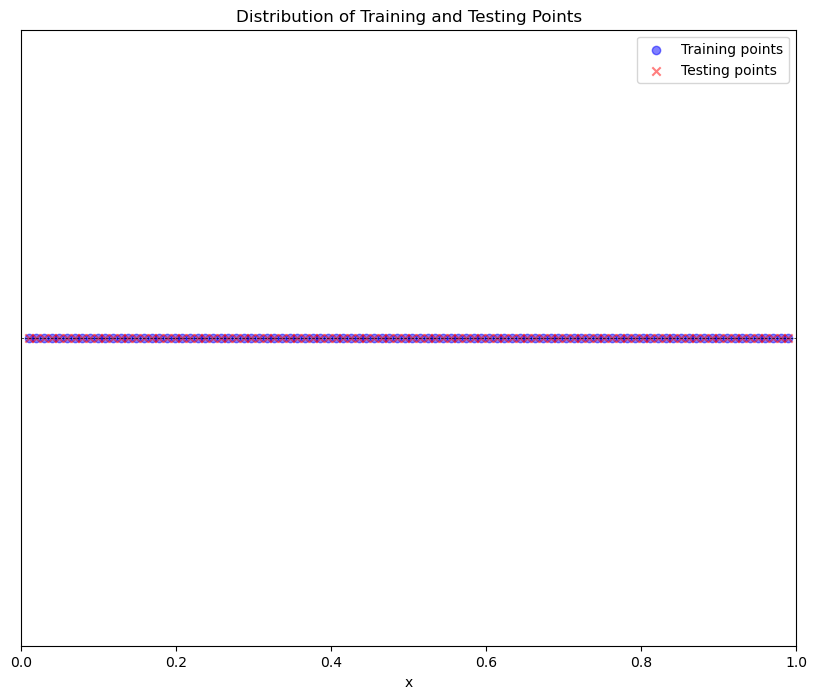

In [5]:
# Obtain training and testing points
train_x = data.train_x
test_x = data.test_x

plt.figure(figsize=(10,8))
plt.scatter(train_x,np.zeros_like(train_x),c='blue',marker='o',label='Training points',alpha=0.5)
plt.scatter(test_x,np.zeros_like(test_x),c='red',marker='x',label='Testing points',alpha=0.5)
plt.title('Distribution of Training and Testing Points')
plt.xlabel('x')
plt.legend()
plt.yticks([])
plt.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
plt.ylim(-0.5,0.5)
plt.xlim(0,1)
plt.show()

## Soft-Constraint PINN with two observed points

In [ ]:
os.makedirs("training_outputs_obs", exist_ok=True)

length = 1
T_hot = 100
T_cold = 20
diff_coeff = 1
density = 1
u = 10

geom = dde.geometry.Interval(0,length)

def pde(x,y):
  dy_dx = dde.grad.jacobian(y,x)
  d2y_dx2 = dde.grad.hessian(y,x)

  return density * u * dy_dx - diff_coeff * d2y_dx2


def func(x):
  return T_hot + (np.exp(density * u * x / diff_coeff)-1) / (np.exp(density * u * length / diff_coeff)-1) * (T_cold - T_hot)

data_x = np.array([0,1]).reshape((2,1))
data_y = func(data_x)

def boundary_left(x,on_boundary):
  return on_boundary and np.isclose(x[0],0)
def boundary_right(x,on_boundary):
  return on_boundary and np.isclose(x[0],1)
    
bc_left = dde.icbc.DirichletBC(geom, lambda x: T_hot, boundary_left)
bc_right = dde.icbc.DirichletBC(geom, lambda x: T_cold, boundary_right)
observe = dde.icbc.PointSetBC(data_x,data_y)

# What works: uniform distribution
data = dde.data.PDE(geom,
                    pde,
                    [bc_left,bc_right,observe],
                    num_domain=100, 
                    solution=func,
                    num_test=100,
                    train_distribution='uniform',
                    anchors=data_x)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation,initializer)

def plot_and_save(step, model):
    # Predict the solution
    y_pred = model.predict(x)
    y_true = func(x)

    # Create the plot
    plt.figure(figsize=(8, 5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('#f0f0f0')
    plt.plot(x, y_true,'-x',color='#2F195F',alpha=0.7,markersize=5, label='Analytical Solution')
    plt.scatter(data_x,data_y,marker='o',s=50,facecolors='none',edgecolors='#A09EBB',label='Data points')
    plt.plot(x, y_pred,'--',color='#37FF8B', label='PINN Prediction')
    plt.title(f'Solution at step {step}',fontsize=14,fontweight='bold',color='#2F195F')
    plt.xlabel('x')
    plt.ylabel('Temperature')
    plt.legend(loc='lower left',fontsize=12,frameon=True,shadow=True,facecolor='white')

    # Save the plot
    plt.savefig(f"training_outputs_obs/step_{step:06d}.png")
    plt.close()

# Generate points for prediction
x = np.linspace(0, length, 50)[:, None]

class PlotCallback(dde.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.step = 0

    def on_epoch_end(self):
        if self.step == 0:
          plot_and_save(self.step, self.model)
        self.step += 1
        if self.step % 50 == 0:  # Save plot every 50 steps
            plot_and_save(self.step, self.model)

# Generate points for prediction
x = np.linspace(0, length, 50)[:, None]

# Create the callback
plot_callback = PlotCallback()

model = dde.Model(data,net)
model.compile("adam", lr=0.001,metrics=["MSE"])
losshistory, train_state = model.train(iterations=5000,callbacks=[plot_callback])

dde.saveplot(losshistory,train_state,issave=False,isplot=True)

def create_gif(image_folder, gif_name):
    images = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(gif_name, images, fps=20)

# Create the animation
create_gif('training_outputs_obs', 'training_animation_obs.gif')